# **Joaquim's additions**

at the end of Parvathy's blog I run the function below with `target_type` as `pd.DataFrame` and `pickle_file` as `blog.pkl`.

In [1]:
def store_all_of_type( target_type, pickle_file ):
    store = {name: _value for name, _value in globals().items() if isinstance(_value, target_type) and not name.startswith('_')}
    import pickle
    with open(pickle_file, 'wb') as file:
        pickle.dump(store, file)
    return store

Now I can reopen this pickle and recover the frames. 

In [2]:
import pickle
from pathlib import Path
pickle_file = 'blog.pkl'

if Path(pickle_file).exists():
    with open(pickle_file, 'rb') as file:
        for key, _value in pickle.load(file).items():
            globals()[key] = _value

From now on this notebook has the dataframes from the first blog's notebook.

Some consistency checks. 

In [3]:
import itertools as it
flatten = it.chain.from_iterable

assert population_aoi[population_meta.columns].isin(population_meta).all(axis=1).all(), \
    'Population in area of interest is not included in the population.'

assert set(flatten(potential_locations.id_with_access)).issubset(set(population_aoi.ID)), \
    'Population listed with access to potential locations is not included in the population in area of interest.'

assert set(flatten(selected_hosp.id_with_access)).issubset(set(population_aoi.ID)), \
    'Population listed with access to the selected hospitals is not included in the population in area of interest.'

I prefer to have my notebooks aware of being running in `colab` or not. 

In [4]:
import os
on_colab = 'COLAB_GPU' in os.environ

# new stuff

`country-bounding-boxes` is only needed to have `folium` maps showing around the country of interest, there is some code for that later. 

In [5]:
if on_colab:
    %pip install country-bounding-boxes
    %pip install pyomo
    %pip install highspy

# Mathematical Optimization

We will now employ _Mathematical Optimization_ to determine the optimal subset of hospitals to open. 
For those unfamiliar with _Mathematical Optimization_, we recommend starting with a hands-on introduction available in [this Jupyter book](https://mobook.github.io/MO-book/intro.html).

At its core, _Mathematical Optimization_ involves creating mathematical models that act as digital twins of the real-world scenarios that we aim to optimize. 
After developing those models, we input relevant data to create specific instances of an optimization problem. These instances are then solved using an appropriate solver to discover the best of all feasible solutions, which we call the optimal solution.

Modeling is a conceptual process, while coding the models is a technical craft. For the latter, we use the package [`pyomo`](https://www.pyomo.org/) as the aforementioned Jupyter book does. 

Please note, the model discussed subsequently is featured as Exercise $3.1$ in a forthcoming textbook from Cambridge University Press, of which the aforementioned Jupyter book is the online companion.

A mathematical optimization model can be seen as a blueprint for the intended optimal solution. Once instantiated, the model is processed by a solver that seeks the optimal solution, if one exists.

For solving instances, we can utilize powerful solvers. For problems such as the one we will describe, [`Gurobi`](https://www.gurobi.com/) is an outstanding commercial solver, while [HiGHS](https://highs.dev/), an excellent open-source alternative, is available under the [MIT license](https://en.wikipedia.org/wiki/MIT_License).

The modeling process begins with identifying the decisions to be made, leading to the definition of decision variables. After naming these decisions and variables, we formalize the objective and constraints using functions of those variables.

- The **objective function** measures the quality of a solution.
- **Constraints** ensure that a solution adheres to all necessary rules to be considered feasible.

In our case, and many others, the functions will be linear, and our variables will have a _binary_ nature to represent _yes/no_ decisions.

For example, we need one variable per household to determine if it is served by an accessible open hospital, and another variable per hospital to indicate whether it is open.

Typical mathematical notation for expressing models starts by naming the sets that support the indices of variables and the model parameters derived from the data.

For our optimization challenge, these include:

### Sets
- **$I$** - the set of households
- **$J$** - the set of potential hospital locations
- **$J_i$** - the set of potential hospital locations within reach of household $i \in I$. Note: $J_i \subseteq J$.

### Parameters
- **$v_i$** - the headcount of household $i \in I$.

### Model `maximal covering` as in the article by [Church and ReVelle](https://www.semanticscholar.org/paper/The-maximal-covering-location-problem-Church-Revelle/c3de804bbeb15b0d8570ee3d9f4cbdf432993cfa)

This model defines variables $z_i$ for each household $i\in I$ to indicate if that household can be served by a hospital that is opened at $j \in J$, leading to the complete model as follows:

\begin{align*}
    \max\quad & \sum_{i\in I} v_iz_i  \\
    \text{subject to:}\quad & z_i \leq \sum_{j\in J_i } x_j & \forall i \in I \\
    & \sum_{j \in J} x_j \leq p \\
    & x_j \in \{0,1\} & \forall j \in J \\
    & z_i \in \{0,1\} & \forall i \in I
\end{align*}

The first line states the objective as to maximize the total headcount of the households served, while the second line (after _subject to:_) lists the first constraint: each household is only served if at least one hospital within reach is open. 
Then the number of hospitals to open constraints the selection and finally the binary nature of the variables used is specified. 

The model above selects up to $p$ hospitals. In the original paper Church and ReVelle selected exactly $p$ hospitals, but our model has advantages to be discussed later.

# Implementing the mathematical model

After the model is designed, implementing it amounts to translating the concepts from the mathematical expressions above into code.

The translation is more or less one on one, the main difference being that the variables are declared prior to using them, as always in programming, while the mathematical formulation traditionally declares the variables at the end. 

We use the package `Pyomo` to code our model.

In [6]:
import pyomo.environ as pyo

In [7]:
def model_max_covering(w, I, J, JI, p):
    m = pyo.ConcreteModel('MaxCovering')

    m.p = pyo.Param(mutable=True, within=pyo.Integers, default=p)
    m.I = pyo.Set(initialize=I)
    m.J = pyo.Set(initialize=J)

    @m.Param(m.I, within=pyo.NonNegativeReals)
    def w(m, i):
        return w[i]

    @m.Param(m.I, within=pyo.Any)
    def JI(m, i):
        return JI.get(i,[])

    m.x = pyo.Var(m.J, within=pyo.Binary)
    m.z = pyo.Var(m.I, within=pyo.Binary)

    @m.Objective(sense=pyo.maximize)
    def covering(m):
        return pyo.quicksum(m.w[i] * m.z[i] for i in m.I)

    @m.Constraint(m.I)
    def serve_if_reachable_and_open(m, i):
        return m.z[i] <= pyo.quicksum(m.x[j] for j in m.JI[i])

    @m.Constraint()
    def budget(m):
        return pyo.quicksum(m.x[j] for j in m.J) <= m.p

    return m

The function below can be used to extract the indices of the variables selected in the optimal solution. 

In [8]:
def get_selected(variables):
    return [k for k, v in variables.items() if v() > 0.5]

# Two main options

We have now two options to instance our model from the data.
 1. Use all hospitals, existing and potential.
 1. Use only the potential hospitals.

The first option requires two things:
 1. All hospitals should have a unique ID regardless of being already opened or not. 
 1. We should **fix** the decision variables of the opened hospitals to $1$.

# Option 1: fix the existing hospitals as open

In [9]:
assert not set(selected_hosp.id).intersection(potential_locations.ID), \
    'The hospital IDs are not unique'

Since the hospital location ids are already globally unique we can proceed. 

In [10]:
w = population_aoi.set_index('ID').population.to_dict()

J_existing = set(selected_hosp.id)
J_potential = set(potential_locations.ID )

J1 = sorted( J_existing | J_potential )
I1 = sorted( set(population_aoi.ID) )

IJ_existing = selected_hosp.set_index('id').id_with_access.to_dict() 
IJ_potential = potential_locations.set_index('ID').id_with_access.to_dict() 

IJ1 = IJ_existing | IJ_potential

In [11]:
def reverse_mapping( mapping ):
    from collections import defaultdict
    aux = defaultdict(set)
    for x, Y in mapping.items():
        for y in Y:
            aux[y].add(x)
    return { y : sorted(aux[y]) for y in sorted(aux.keys()) }

In [12]:
JI1 = reverse_mapping( IJ1 )

Below we instance the model from the data.
We consider the installation of $6$ additional hospitals.

In [13]:
budget = 6
m1 = model_max_covering(w, I1, J1, JI1, budget)

Now we extend the model to fix the variables of the selected hospitals to take the value $1$. 

In [14]:
m1.Jfixed = pyo.Set(initialize=sorted(J_existing))

@m1.Constraint(m1.Jfixed)
def fix_open(m1,j):
    return m1.x[j] == 1

Now we set the budget parameter $p$ to the maximum number of hospitals that we want to find open in the optimal solution. 
Since the existing hospitals are certain to be included, we need to add the desired number of new hospitals to the parameter $p$ of the model. 

Since our model has all hospitals we need to tell it that we want to have the existing ones plus the original budget in the optimal solution.

In [15]:
m1.p = m1.p()+len(J_existing)

We are now ready to solve our problem. 
That is not done by `Pyomo` but by a solver, via `Pyomo`.
This means that we can easily compare the behavior of different solvers.
This notebook assumes the `HiGHS` solver, but we can easily ask `Pyomo` which solvers are available at the moment of execution.

In [16]:
def ListAvailablePyomoSolvers():
    import subprocess
    shell_command = "pyomo help --solvers"
    output = subprocess.check_output(shell_command, shell=True).decode()
    return [
        line.strip()[1:]
        for line in output.split()
        if line.strip().startswith("+") and not line.strip().endswith(")")
    ]

In [17]:
ListAvailablePyomoSolvers()

['appsi_gurobi',
 'appsi_highs',
 'cbc',
 'cplex_direct',
 'cplex_persistent',
 'gdpopt',
 'gdpopt.enumerate',
 'gdpopt.gloa',
 'gdpopt.lbb',
 'gdpopt.loa',
 'gdpopt.ric',
 'glpk',
 'gurobi',
 'gurobi_direct',
 'gurobi_persistent',
 'gurobi_v2',
 'ipopt',
 'ipopt_v2',
 'mindtpy',
 'mindtpy.ecp',
 'mindtpy.fp',
 'mindtpy.goa',
 'mindtpy.oa',
 'mosek',
 'mosek_direct',
 'mosek_persistent',
 'mpec_minlp',
 'mpec_nlp',
 'multistart',
 'scipy.fsolve',
 'scipy.newton',
 'scipy.root',
 'scipy.secant-newton',
 'trustregion']

In [18]:
f'Our instanced model has {m1.nvariables():,} variables and {m1.nconstraints():,} constraints'

'Our instanced model has 14,210 variables and 13,904 constraints'

The commercial solver `Gurobi` has a community edition that freely solves instances with up to $2,000$ variables and $2,000$ constraints, our instance is beyond the reach of that free tier.

The `HiGHS` solver is available to `Pyomo` via its [Auto-Persistent Pyomo Solver Interface](https://pyomo.readthedocs.io/en/stable/library_reference/appsi/appsi.html).

In [19]:
solver = pyo.SolverFactory('appsi_highs')

And now we finally solve our problem. 
We will deliberately ask the solver to share it's execution log with us, by setting `tee=True`. 
This is akin to saying, "I want to 'T'-split the output: show it on my screen and proceed with the operation." 
A clear reminiscence from Unix's original `tee` command, nowadays [present in many shells](https://en.wikipedia.org/wiki/Tee_(command)).

In [20]:
result = solver.solve(m1,tee=True)

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12471 rows, 12772 cols, 528435 nonzeros
683 rows, 867 cols, 6659 nonzeros
682 rows, 753 cols, 3470 nonzeros

Solving MIP model with:
   682 rows
   753 cols (741 binary, 12 integer, 0 implied int., 0 continuous)
   3470 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   112991.175173   -inf                 inf        0      0      0         0     0.3s
 T       0       0         0   0.00%   112991.175173   111771.029499      1.09%        0      0      0       261     0.3s

Solving report
  Status            Optimal
  Primal bound      111771.029499
  Dual bound        111771.029499
  Gap               0% (tolerance: 0.01%)
 

To be sure, we check the termination condition to realize that the problem has been solved to optimality (in fact, to optimality for the default [numerical tolerances](https://ergo-code.github.io/HiGHS/dev/options/definitions/)).

In [21]:
result.Solver.Termination_condition

<TerminationCondition.optimal: 'optimal'>

As a sanity check we can confirm that the existing hospitals are indeed all present in the solution found. 

In [22]:
assert J_existing.issubset(set(get_selected(m1.x))), \
    'The optimal solution ignores hospitals that are already'

# Let us look at the solution

In [23]:
import folium as fl

In [24]:
def fit_to_bounding_box( 
        folium_map : fl.Map,
        lon_min: float, lat_min: float, 
        lon_max: float, lat_max: float
    ) -> fl.Map:
    folium_map.fit_bounds(((lat_min, lon_min), (lat_max, lon_max)))
    return folium_map

def get_folium_map_for_bounds(
    lon_min: float, lat_min:float, 
    lon_max: float, lat_max: float,
    **kwargs
    ) -> fl.Map:
    """
    Generates a folium map around the given bounding box 
    Parameters:
    - lon_min: minimum longitude in bounding box
    - lat_min: minimum latitude in bounding box
    - lon_max: maximum longitude in bounding box
    - lat_max: maximum latitude in bounding box
    - kwargs: Additional keyword arguments for folium.Map.
    
    Returns:
    - A folium.Map object around the given bounds
    """
    start_coords = ((lat_max + lat_min) / 2, (lon_max + lon_min) / 2)
    folium_map = fl.Map(location=start_coords,**kwargs)
    return fit_to_bounding_box( folium_map, lon_min, lat_min, lon_max, lat_max )


def get_folium_map_for_country(country_code,**kwargs) -> fl.Map:
    """
    Generates a folium map for the specified country by its ISO 3166-1 alpha-2 code.
    See: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2
    Parameters:
    - country_code: ISO alpha-2 code of the country.
    - kwargs: Additional keyword arguments for folium.Map.

    Note: passing `location` and `zoom_start` does not affect the result as they are overruled.

    Returns:
    - A folium.Map object centered and zoomed in on the specified country.
    """
    from country_bounding_boxes import country_subunits_by_iso_code
    susbb = [su.bbox for su in country_subunits_by_iso_code(country_code)]
    if susbb:
        bbox = *min(susbb)[:2],*max(susbb)[2:]
        return get_folium_map_for_bounds( *bbox,**kwargs )
    return fl.Map( **kwargs )

def fit_around(folium_map: fl.Map,
               latitude: float, longitude: float,
               delta_lat: float = 0.13, delta_lon: float = 0.11) -> fl.Map:
    """
    Adjusts the map to fit a specified area around a given latitude and longitude,
    using delta values for latitude and longitude to define the area size.

    Parameters:
    - folium_map: The folium.Map object to adjust.
    - latitude: Latitude of the center point.
    - longitude: Longitude of the center point.
    - delta_lat: Latitude delta for the bounding area.
    - delta_lon: Longitude delta for the bounding area.

    Returns:
    - The adjusted folium.Map object.
    """
    folium_map.fit_bounds(
        ((latitude - delta_lat, longitude - delta_lon),
         (latitude + delta_lat, longitude + delta_lon))
        )
    return folium_map

def folium_to_png(folium_map: fl.Map, file_name: str,
                  rendering_seconds: int = 5,
                  crop: tuple[int, int, int, int] = (300, 123, 1068, 557)
                  ) -> None:
    """
    Saves a folium map as a PNG image file, with optional cropping.

    Parameters:
    - folium_map: The folium.Map object to save.
    - file_name: The name of the output file without extension.
    - rendering_seconds: Time in seconds to wait for map rendering.
    - crop: A tuple defining the cropping area as (left, top, right, bottom).

    Returns:
    - None
    """
    from PIL import Image
    import io
    # since we are calling a private function, this might need to be updated based on folium's API changes
    img_data = folium_map._to_png(rendering_seconds)
    img = Image.open(io.BytesIO(img_data))
    if crop:
        img = img.crop(crop)
    img.save(f'{file_name}.png')

In [25]:
import geopandas as gpd
from shapely.ops import unary_union

In [26]:
def select_by_ID( df, idx ):
    return df[df.ID.isin(idx)]

def add_these( points, color, container, radius=2 ):
    import itertools as it
    if isinstance(color, list):
        these = zip(points,it.cycle(color))
    else:
        these = zip(points,it.repeat(color,len(points)))
    for p,c in these:
        fl.CircleMarker(
            location=[p.y,p.x],
            radius=radius,
            color='black',
            weight=.5,
            fill=True,
            fill_color=c,
            fill_opacity=0.9).add_to(container)


In [27]:
def show_solution( selection, 
                 selected_gadm=selected_gadm, 
                 selected_hosp=selected_hosp,
                 potential_locations=potential_locations
                 ):
    selected = selected_gadm.iloc[0]

    folium_map = get_folium_map_for_bounds(*selected.geometry.bounds, tiles='OpenStreetMap')

    fl.TileLayer("Cartodb Positron").add_to(folium_map)

    fl.GeoJson(
        data=selected.geometry,
        name=selected.NAME_1,
        style_function=lambda x: {'color': 'orange'}
    ).add_to(folium_map)

    fl.GeoJson(
        data=unary_union(selected_hosp.cachment_area_mapbox),
        name='Access to existing hospitals',
        style_function=lambda _: dict(fillColor='green', fillOpacity=0.5, color='green', weight=0.1)
    ).add_to(folium_map)
    
    if selection:
        fl.GeoJson(
            data=unary_union(select_by_ID(potential_locations, selection).cachment_area_mapbox).difference(unary_union(selected_hosp.cachment_area_mapbox)),
            name='Access to newly selected locations',
            style_function=lambda _: dict(fillColor='red', fillOpacity=0.5, color='red', weight=0.1)
        ).add_to(folium_map)

        solution = fl.FeatureGroup('Optimally selected new locations')
        add_these( select_by_ID( potential_locations, selection ).geometry, 
                'cyan', solution, radius=3 )
        solution.add_to(folium_map)

    existing = fl.FeatureGroup('Previously existing hospitals')
    add_these( selected_hosp.geometry, 'yellow', existing, radius=3 )
    existing.add_to(folium_map)

    fl.LayerControl().add_to(folium_map)

    return folium_map

In [28]:
show_solution( get_selected(m1.x) )

Above we see in green the joint catchment area of all existing hospitals, while in red we show the extension provided by the nre hospitals (we deliberately made those two geometries disjunct for clarity).

# Option 2: consider only the potential hospitals

This option ignores the existing hospitals and all those that are already served. 

In [29]:
served = set(flatten(selected_hosp.id_with_access))

J2 = sorted( J_potential )
I2 = sorted( set(population_aoi.ID) - served )

IJ2 = { j : sorted( set(Ij)-served) for j,Ij in IJ_potential.items() }
JI2 = reverse_mapping(IJ2)

In [30]:
m2 = model_max_covering(w,I2,J2,JI2,budget)
result = solver.solve(m2)
f'Solved a model with {m2.nvariables():,} variables and {m2.nconstraints():,} constraints and found an {result.Solver.Termination_condition} solution'

'Solved a model with 2,297 variables and 1,991 constraints and found an optimal solution'

Our new version instanced faster, solved faster and is almost within the allowed sizes for the community edition of `Gurobi`.

Did it find the same solution?

In [31]:
show_solution(get_selected(m2.x))

It does not look exactly the same. 
Let's check more thoroughly. 

Model 1 selects the existing hospitals plus a set of at most `budget` new ones, while model 2 selects a set of at most `budget` to add to the existing ones.

What we need to check is that the total headcounts from both models are the same. 

We already have the set of households served by the existing facilities, therefore we focus on the newly covered households. 

In [32]:
covered_by = lambda selection : set(flatten(select_by_ID(potential_locations,selection).id_with_access)) | served

headcount = lambda covered : select_by_ID(population_aoi,covered).population.sum()

In [33]:
assert headcount(covered_by(get_selected(m1.x))) == headcount(covered_by(get_selected(m1.x))), \
    'The sum of headcounts covered differ'

The solutions cover the same total headcounts. 

# Further reductions: option 3

That the solutions found before may differ is partially explained by candidate locations that are dominated by others.

We consider that a potential location is dominated if the set of households it covers is contained in another. 

Since each hospital 'costs' the same with respect to the `budget`, the one covering more is always preferred to the dominated one. 

In [34]:
covered_by_potential_locations = {
    id: set(with_access) for id,with_access in potential_locations[['ID','id_with_access']].values
}

In [35]:
dominated = {
    id for id,covers in covered_by_potential_locations.items() \
        if any( covers.issubset(others) \
                for other_id,others in covered_by_potential_locations.items() \
                    if id != other_id 
            )
}

In [36]:
J3 = sorted( J_potential-dominated )
IJ3 = { j : IJ2[j] for j in J3}
I3 = sorted(set(flatten(IJ3.values())))
JI3 = reverse_mapping(IJ3)

In [37]:
m3 = model_max_covering(w,I3,J3,JI3,budget)

In [38]:
results = solver.solve(m3)

In [39]:
m3.nvariables(),m3.nconstraints(),result.Solver.Termination_condition

(853, 683, <TerminationCondition.optimal: 'optimal'>)

In [40]:
headcount(covered_by(J_existing))

107882.265475

In [41]:
[headcount(covered_by(get_selected(m.x))) for m in [m1,m2,m3]]

[111771.029499, 111771.029499, 111771.029499]

Since we have three instances of our model that all give the same optimal solution, we will now proceed with the smallest, the third. 

# How to determine the right budget?

We can solve for a number of budgets and see the benefits: the highest coverage that a solution can yield for each budget. 

In [42]:
results = dict()
for b in range(100):
    m3.p = b
    solver.solve(m3)    
    results[b] = dict(solution=get_selected(m3.x),coverage=headcount(covered_by(get_selected(m3.x))))

In [43]:
import pandas as pd
result_frame = pd.DataFrame.from_dict( results, orient='index' )

This results in a curve which in fact is a [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) that enables decision makers on deciding which budget to allocate in order to benefit accessibility. 

<Axes: >

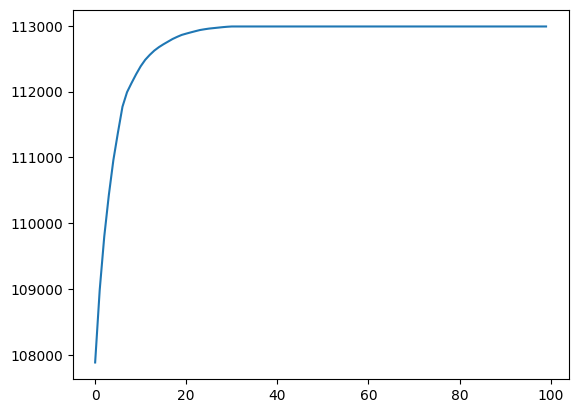

In [44]:
result_frame.coverage.plot()

One may prefer to see relative coverage instead of absolute headcounts. 

In [45]:
result_frame['relative'] = result_frame.coverage / population_aoi.population.sum() * 100

<Axes: >

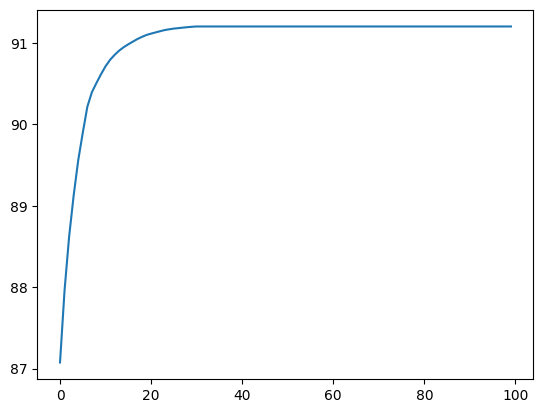

In [46]:
result_frame.relative.plot()

That the curve flattens is explained by the fact that even opening hospitals at all the potential locations does not serve everybody. 
This is likely to be explained by a combination of factors, important ones being the road infrastructure available and the selection of candidate locations. 

Nevertheless, we can focus our attention on the range of budgets that matter.

In [47]:
idx_max = result_frame.coverage.idxmax()

<Axes: >

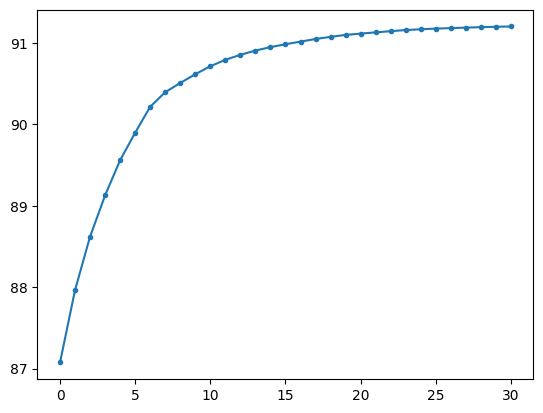

In [48]:
result_frame[:(idx_max+1)].relative.plot(style='.-')

The decision maker may decide that opening $10$ additional hospitals gives the best option. 

In [49]:
result_frame.loc[10].relative

90.71116943868307

Below we see the solution.

In [50]:
show_solution(result_frame.loc[10].solution)